# How to create leakage-robust single-qubit gates
**Design pulses that minimize leakage to unwanted states**

Boulder Opal exposes a highly-flexible [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) for general-purpose gradient-based optimization. It allows one to define the physical problem in a higher dimensional quantum system while retaining the ability to optimize for a target operation in a particular subspace. In this notebook we demonstrate the optimization of a single-qubit gate in a superconducting transmon system with three levels.

## Summary workflow
### 1. Define optimization subspace in the graph
The flexible Boulder Opal optimization engine expresses all optimization problems as [data flow graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs), which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize). For an optimal control problem, the cost is typically given by the gate infidelity with respect to a user-defined `target` operation. You can restrict this target operation to a subspace of your full quantum system by multiplying it by the appropriate subspace projector. This ensures that the projected target treats population outside the desired subspace as leakage error. For example, the qubit projector in a three-dimensional space is 
$$ P_{\rm{qubit}} = \begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 0 
\end{pmatrix}  .$$

The target operator is defined using the `graph.target` graph operation:
```python
target_operator = graph.target(
    full_target.dot(qubit_projector), filter_function_projector=qubit_projector
)
```
where `full_target` is your original target operator in the full space. The `filter_function_projector` parameter is optional and should be used when you also want to add [robustness to noise](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-create-dephasing-and-amplitude-robust-single-qubit-gates) in that subspace.   

Once this is defined, we calculate the infidelity by passing this operator to the `graph.infidelity_pwc` graph operation
```python
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=target_operator, name="infidelity"
)
```
### 2. Execute graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. The cost, the outputs, and the graph must be provided. The function returns the results of the optimization. 

## Example: Optimize single-qubit Hadamard in a qutrit system

In this example, we consider a qutrit system in which we effect a single-qubit gate robust against control noise while simultaneously minimizing leakage out of the computational subspace. The system is described by the following Hamiltonian:
$$
H(t) = \frac{\chi}{2} (a^\dagger)^2 a^2 + (1+\beta(t))\left(\gamma(t) a + \gamma^*(t) a^\dagger \right) + \frac{\alpha(t)}{2} a^\dagger a , 
$$
where $\chi$ is the anharmonicity, $\gamma(t)$ and $\alpha(t)$ are, respectively, complex and real time-dependent pulses, $\beta(t)$ is a small, slowly-varying stochastic amplitude noise process, and $a = |0 \rangle \langle 1 | + \sqrt{2} |1 \rangle \langle 2 |$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

We start by defining the operators and physical parameters:

In [2]:
# Define target and projector matrices
hadamard = np.array(
    [[1.0, 1.0, 0], [1.0, -1.0, 0], [0, 0, np.sqrt(2)]], dtype=complex
) / np.sqrt(2)
qubit_projector = np.pad(np.eye(2), ((0, 1), (0, 1)), mode="constant")

# Define physical constants and parameters
transmon_levels = 3
chi = 2 * np.pi * -300.0 * 1e6  # Hz
gamma_max = 2 * np.pi * 30e6  # Hz
alpha_max = 2 * np.pi * 30e6  # Hz
segment_count = 50
duration = 100e-9  # s
sinc_cutoff_frequency = 300e6

Below we show how to create a data flow graph for optimizing the system described above. Note that we are using a filter to produce smooth pulses as explained in our [How to add smoothing and band-limits to optimized controls](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls) user guide. 

In [3]:
# Create graph object
graph = bo.Graph()

# Define standard matrices
a = graph.annihilation_operator(transmon_levels)
ad = graph.creation_operator(transmon_levels)
ada = graph.number_operator(transmon_levels)
ad2a2 = ada @ ada - ada

# Create the complex optimizable gamma(t) signal
gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, maximum=gamma_max, duration=duration
)

# Create the optimizable alpha(t) signal
alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    minimum=-alpha_max,
    maximum=alpha_max,
    duration=duration,
)

# Create filtered signals
sinc_kernel = graph.sinc_convolution_kernel(sinc_cutoff_frequency)
rediscretized_gamma = graph.filter_and_resample_pwc(
    pwc=gamma, kernel=sinc_kernel, segment_count=256, name="gamma"
)
rediscretized_alpha = graph.filter_and_resample_pwc(
    pwc=alpha, kernel=sinc_kernel, segment_count=256, name="alpha"
)

# Create Hamiltonian terms
anharmonicity = ad2a2 * chi / 2
drive = graph.hermitian_part(2 * rediscretized_gamma * a)
shift = rediscretized_alpha * ada / 2
hamiltonian = anharmonicity + drive + shift

# Create the target operator in the qubit subspace
target_operator = graph.target(
    hadamard.dot(qubit_projector), filter_function_projector=qubit_projector
)

infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=target_operator,
    noise_operators=[drive],
    name="infidelity",
)

We can now run the optimization and plot the resulting control pulses:

Your task (action_id="1828094") has started.
Your task (action_id="1828094") has completed.

Optimized cost:	5.782e-10


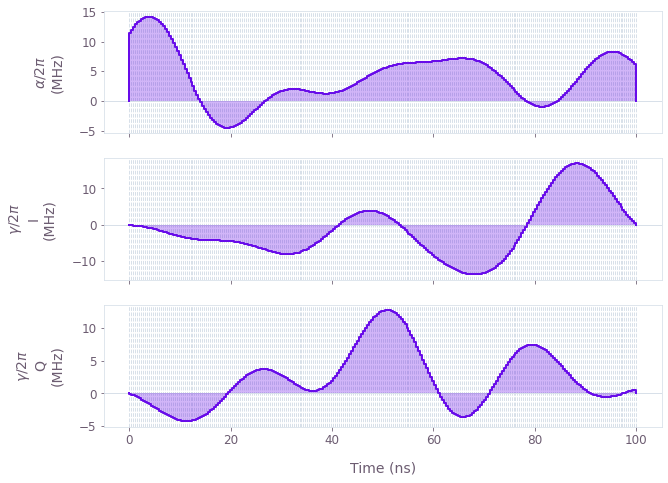

In [4]:
# Run the optimization
optimization_result = bo.run_optimization(
    cost_node_name="infidelity",
    output_node_names=["alpha", "gamma"],
    graph=graph,
    optimization_count=4,
)

print(f"\nOptimized cost:\t{optimization_result['cost']:.3e}")

# Plot the optimized controls
qv.plot_controls(
    {
        "$\\alpha$": optimization_result["output"]["alpha"],
        "$\\gamma$": optimization_result["output"]["gamma"],
    },
    polar=False,
)